In [1]:
# 1. Загрузить данные + создать свои
    # 1.1. Датасеты: Kddcup 99, ForestCover, Shuttle, свои данные (в качестве примера работы)
# 2. Создать функцию, создающую модель и прогноз модели по данным из каждого датасета
    # 2.1. Будем сравнивать с LOF и SVM
    # 2.2. Будем менять характеристики IF, такие как количество деревьев, сэмплирование (?)
# 3. Построить графики ROC и вычислить AUC
# 4. Сделать выводы...

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas
import sklearn
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.inspection
import sklearn.neighbors
import sklearn.compose
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm
import time

#### 1. Загрузка данных

In [3]:
data = {}
# {"dataset": [x_data, y_data, anom_perc] }

In [4]:
# KDDCUP99-http
X_KDDCUP99, Y_KDDCUP99 = sklearn.datasets.fetch_kddcup99(subset = "http", percent10 = True, random_state = 0, return_X_y = True, as_frame = True)
# duration, src_bytes, dst_bytes
Y_KDDCUP99 = (Y_KDDCUP99 != b"normal.").astype("int32")

X_KDDCUP99, _, Y_KDDCUP99, _ = sklearn.model_selection.train_test_split(X_KDDCUP99, Y_KDDCUP99, train_size=0.1, stratify=Y_KDDCUP99, random_state=0)

samples_KDDCUP99 = X_KDDCUP99.shape[0] 
anom_perc_KDDCUP99 = Y_KDDCUP99.mean()

print(f"Набор данных Kddcup 99 (подмножество http): {samples_KDDCUP99} нормальных точек, {Y_KDDCUP99.sum()} аномальных точек, \nдоля аномалий: {anom_perc_KDDCUP99}")

data["Kddcup 99 (html)"] = [X_KDDCUP99, Y_KDDCUP99, anom_perc_KDDCUP99]

Набор данных Kddcup 99 (подмножество http): 5872 нормальных точек, 221 аномальных точек, 
доля аномалий: 0.03763623978201635


In [5]:
# ForestCover
# будем считать, что нормальными являются данные класса 2, 
# а аномальными - класса 4
X_FCOVER, Y_FCOVER = sklearn.datasets.fetch_covtype(return_X_y = True, as_frame = True)
ind = (Y_FCOVER == 2) + (Y_FCOVER == 4)
X_FCOVER = X_FCOVER.loc[ind]; Y_FCOVER = Y_FCOVER.loc[ind]
Y_FCOVER = (Y_FCOVER != 2).astype("int32")

X_FCOVER, _, Y_FCOVER, _ = sklearn.model_selection.train_test_split(X_FCOVER, Y_FCOVER, train_size=0.1, stratify=Y_FCOVER, random_state = 0)

samples_FCOVER = X_FCOVER.shape[0]
anom_perc_FCOVER = Y_FCOVER.mean()

print(f"Набор данных ForestCover: {samples_FCOVER} нормальных точек, {Y_FCOVER.sum()} аномальных точек, \nдоля аномалий: {anom_perc_FCOVER}")

data["Forest Cover"] = [X_FCOVER, Y_FCOVER, anom_perc_FCOVER]

Набор данных ForestCover: 28604 нормальных точек, 275 аномальных точек, 
доля аномалий: 0.009614039994406376


In [6]:
# Shuttle
# будем считать, что нормальными являются данные классов 1 и 4,
# а все остальные — аномальными
def load_data(fname):
    X = []
    Y = []
    
    X = pandas.read_csv(fname, sep=" ", header=None)
    Y = X[X.columns[-1]]
    X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)
    
    return X, Y

X_SHUTTLE, Y_SHUTTLE = load_data("Shuttle/shuttle.trn")
Y_SHUTTLE = np.logical_and(Y_SHUTTLE != 1, Y_SHUTTLE != 4).astype("int32")

X_SHUTTLE, _, Y_SHUTTLE, _ = sklearn.model_selection.train_test_split(X_SHUTTLE, Y_SHUTTLE, stratify=Y_SHUTTLE, random_state = 0)

samples_SHUTTLE = X_SHUTTLE.shape[0]
anom_perc_SHUTTLE = Y_SHUTTLE.mean()

print(f"Набор данных Shuttle: {samples_SHUTTLE} нормальных точек, {Y_SHUTTLE.sum()} аномальных точек, \nдоля аномалий: {anom_perc_SHUTTLE}")

data["Shuttle"] = [X_SHUTTLE, Y_SHUTTLE, anom_perc_SHUTTLE]

Набор данных Shuttle: 32625 нормальных точек, 1983 аномальных точек, 
доля аномалий: 0.0607816091954023


In [23]:
# Свои данные
X_MY, Y_MY = load_data("MyData/data.txt")
Y_MY = (Y_MY != 1).astype("int32")

X_MY, _, Y_MY, _ = sklearn.model_selection.train_test_split(X_MY, Y_MY, stratify=Y_MY, random_state = 0)

samples_MY = X_MY.shape[0]
anom_perc_MY = Y_MY.mean()

print(f"Собственный набор данных: {samples_MY} нормальных точек, {Y_MY.sum()} аномальных точек, \nдоля аномалий: {anom_perc_MY}")

data["My Data"] = [X_MY, Y_MY, anom_perc_MY]

Собственный набор данных: 2327 нормальных точек, 179 аномальных точек, 
доля аномалий: 0.07692307692307693


#### 2. Создание моделей и прогнозов на основе этих моделей

In [25]:
def MakeModel(name, kwargs):
    if "iforest" in name:
        detector = sklearn.ensemble.IsolationForest(**kwargs)
        preproc = None
        
    elif name == "lof":
        detector = sklearn.neighbors.LocalOutlierFactor(**kwargs)
        preproc = sklearn.preprocessing.RobustScaler()
        
    elif name == "svm":
        detector = sklearn.svm.OneClassSVM(**kwargs)
        preproc = None
        
    return sklearn.pipeline.make_pipeline(preproc, detector)

def MakePred(name, detector, X):
    t = time.perf_counter()
    if name == "lof":
        pred = detector.fit_predict(X)
    else:
        pred = detector.fit(X).predict(X)
    print(name, time.perf_counter() - t)
    return pred

datasets = data.keys()
report = { setname: {} for setname in datasets }
models = ["iforest n_est 100 s 256", "iforest n_est 5 samples 256", "iforest n_est 100 samples 64", "iforest n_est 5 samples 64", "lof", "svm"]
for setname in datasets:
    print(setname)
    dataset = data[setname]
    X = dataset[0]
    N = X.shape[0]
    Y = dataset[1]
    anom_perc = dataset[2]
    for modelname in models:
        # Создание аргументов
        if modelname == "iforest n_est 100 s 256":
            args = {"random_state": 0, "contamination": anom_perc}
        elif modelname == "iforest n_est 5 samples 256":
            args = {"random_state": 0, "n_estimators": 5, "contamination": anom_perc}
        elif modelname == "iforest n_est 100 samples 64":
            args = {"random_state": 0, "max_samples": 64, "contamination": anom_perc}
        elif modelname == "iforest n_est 5 samples 64":
            args = {"random_state": 0, "n_estimators": 5, "max_samples": 64, "contamination": anom_perc}
        elif modelname == "lof":
            args = {"n_neighbors": int(N * anom_perc), "contamination": anom_perc}
        elif modelname == "svm":
            args = {"gamma": "scale", "nu": anom_perc}
        
        model = MakeModel(modelname, args)
        Ypred = MakePred(modelname, model, X)
        Ypred -= 1
        Ypred //= -2
        report[setname][modelname] = [Y, Ypred]

Kddcup 99 (html)
iforest n_est 100 s 256 0.18502489995444193
iforest n_est 5 samples 256 0.014305800024885684
iforest n_est 100 samples 64 0.15250560001004487
iforest n_est 5 samples 64 0.012971199990715832
lof 0.25811009999597445
svm 0.1655699000111781
Forest Cover
iforest n_est 100 s 256 0.38361119996989146
iforest n_est 5 samples 256 0.02894009998999536
iforest n_est 100 samples 64 0.29244240000844
iforest n_est 5 samples 64 0.025294999999459833
lof 1.588035199965816
svm 1.5307086000102572
Shuttle
iforest n_est 100 s 256 0.4487811999861151
iforest n_est 5 samples 256 0.027917100000195205
iforest n_est 100 samples 64 0.3243191000074148
iforest n_est 5 samples 64 0.023124100000131875
lof 27.733028100046795
svm 10.408766800013836
My Data
iforest n_est 100 s 256 0.12986739998450503
iforest n_est 5 samples 256 0.009231500036548823
iforest n_est 100 samples 64 0.12228479998884723
iforest n_est 5 samples 64 0.009004999999888241
lof 0.06354700005613267
svm 0.05118980002589524


#### 3. Построение графиков ROC и вычисление AUC 

In [31]:
for setname in datasets:
    for modelname in models:
        print(setname, modelname, sklearn.metrics.roc_auc_score(report[setname][modelname][0], report[setname][modelname][1]))
        
for setname in datasets:
    for modelname in models:
        print(sklearn.metrics.roc_auc_score(report[setname][modelname][0], report[setname][modelname][1]), end=" ")
    print("\n")

Kddcup 99 (html) iforest n_est 100 s 256 0.5314592139620505
Kddcup 99 (html) iforest n_est 5 samples 256 0.5125129016527727
Kddcup 99 (html) iforest n_est 100 samples 64 0.9931241897681987
Kddcup 99 (html) iforest n_est 5 samples 64 0.9930357098531394
Kddcup 99 (html) lof 0.4827968621258721
Kddcup 99 (html) svm 0.9741266311732758
Forest Cover iforest n_est 100 s 256 0.6713861478279566
Forest Cover iforest n_est 5 samples 256 0.6879615812899726
Forest Cover iforest n_est 100 samples 64 0.5281912848703064
Forest Cover iforest n_est 5 samples 64 0.5465496006341076
Forest Cover lof 0.5318629480230667
Forest Cover svm 0.5281559853539097
Shuttle iforest n_est 100 s 256 0.939327884038016
Shuttle iforest n_est 5 samples 256 0.7845165895622879
Shuttle iforest n_est 100 samples 64 0.9731539309902726
Shuttle iforest n_est 5 samples 64 0.876605987391753
Shuttle lof 0.7119416795256251
Shuttle svm 0.7645436573119411
My Data iforest n_est 100 s 256 0.9939478584729982
My Data iforest n_est 5 samples 2

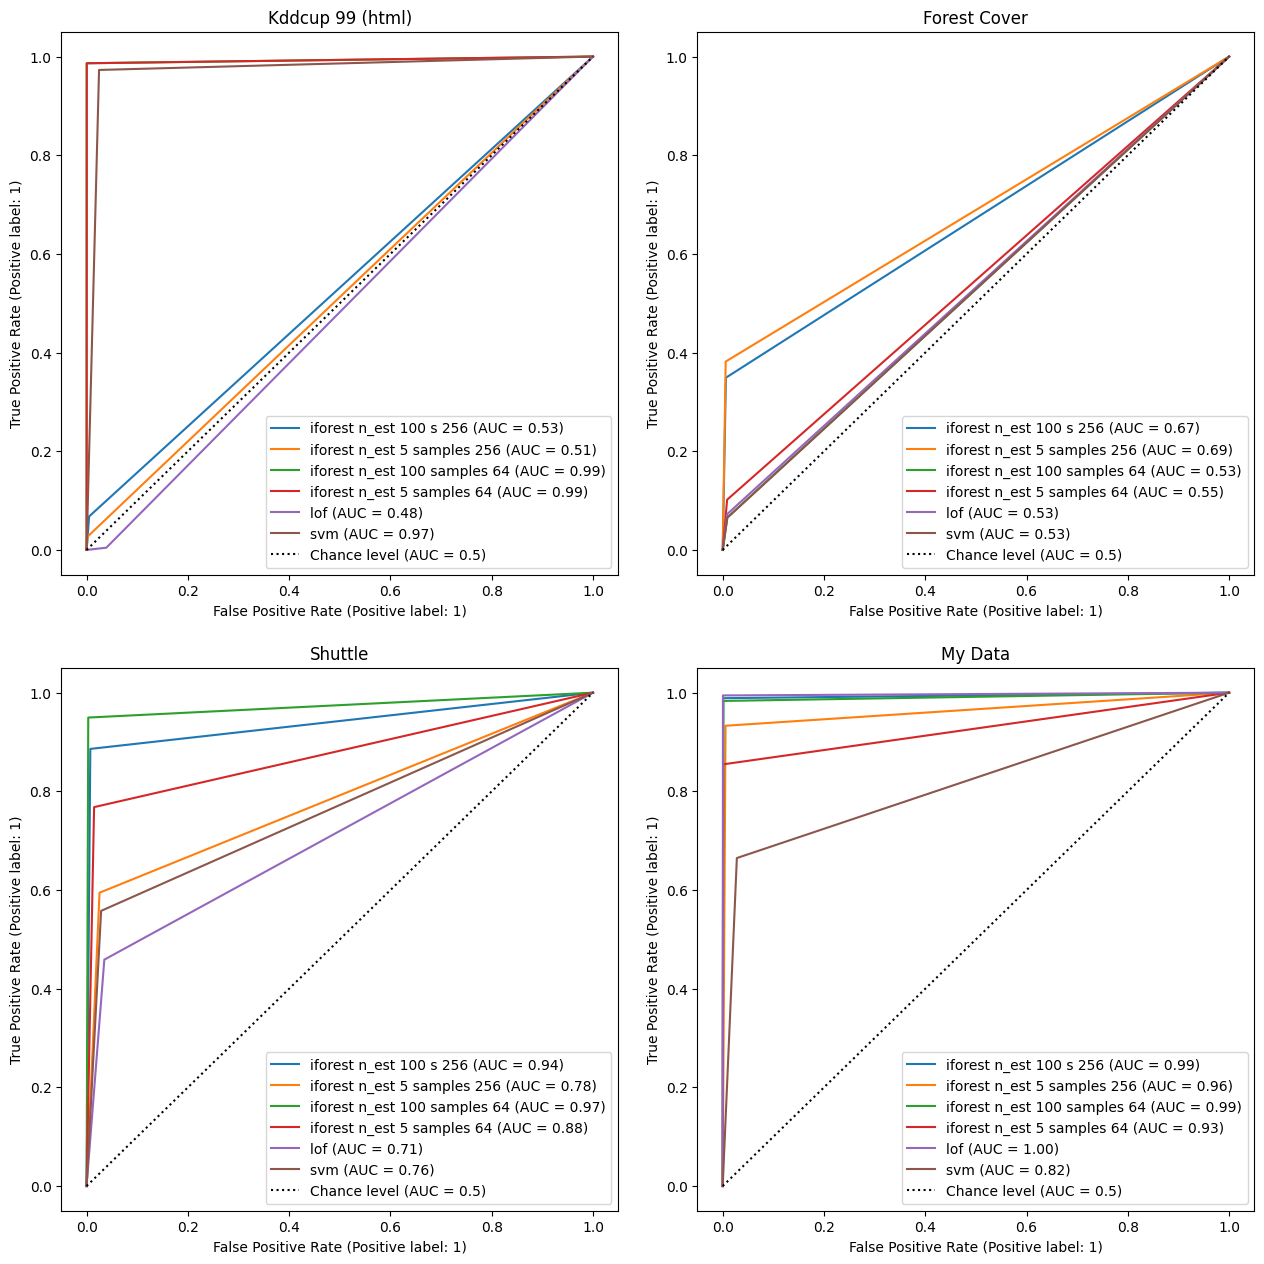

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(13,13))
for subax, setname in zip(axs.ravel(), datasets):
    for modelname in models:
        PredDisp = sklearn.metrics.RocCurveDisplay.from_predictions(report[setname][modelname][0], report[setname][modelname][1], 
                                                                   pos_label = 1, name = modelname, ax = subax, plot_chance_level = (modelname == "svm"),
                                                                   chance_level_kw = {"linestyle": ":"})
    subax.set_title(setname)
plt.tight_layout(pad = 2.0)